In [1]:
pip install gym torch matplotlib

Using device: cuda


/usr/local/lib/python3.10/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.10/dist-packages/gym/core.py:256: DeprecationWarning: WARN: Function `env.seed(seed)` is marked as deprecated and will be removed in the future. Please use `env.reset(seed=seed)` instead.
  deprecation(


Episode 10/1000, Reward: -1219.98, Average Reward: -1475.17
Episode 20/1000, Reward: -900.10, Average Reward: -1237.03
Episode 30/1000, Reward: -375.99, Average Reward: -1042.05
Episode 40/1000, Reward: -134.36, Average Reward: -833.98
Episode 50/1000, Reward: -256.14, Average Reward: -704.95
Episode 60/1000, Reward: -5.17, Average Reward: -650.65
Episode 70/1000, Reward: -121.82, Average Reward: -582.67
Episode 80/1000, Reward: -117.03, Average Reward: -542.20
Episode 90/1000, Reward: -231.80, Average Reward: -495.20
Episode 100/1000, Reward: -115.95, Average Reward: -461.20
Episode 110/1000, Reward: -240.83, Average Reward: -331.43
Episode 120/1000, Reward: -229.76, Average Reward: -249.24
Episode 130/1000, Reward: -242.23, Average Reward: -197.51
Episode 140/1000, Reward: -232.70, Average Reward: -195.74
Episode 150/1000, Reward: -116.72, Average Reward: -195.09
Episode 160/1000, Reward: -123.47, Average Reward: -168.13
Episode 170/1000, Reward: -246.92, Average Reward: -168.75
Epis

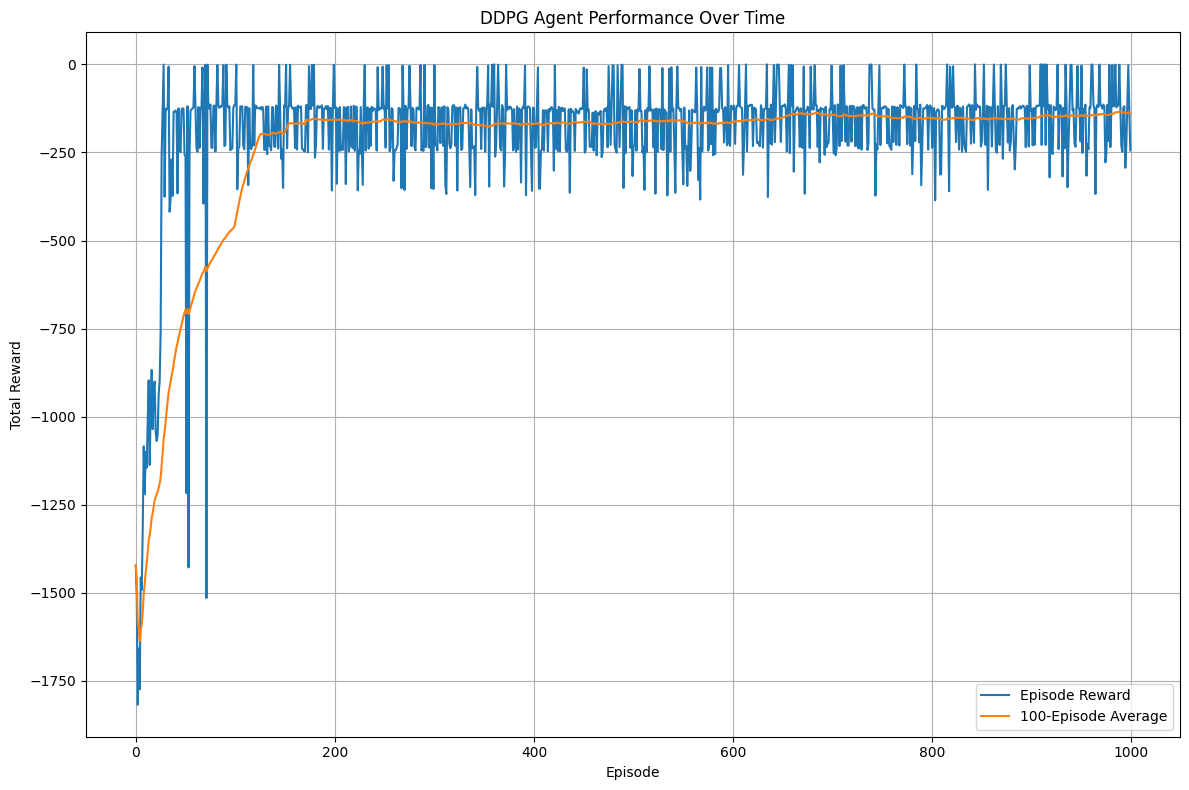

Actor and Critic models saved in ddpg_models/


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
from collections import deque
import random
import matplotlib.pyplot as plt
import os

# Set random seeds for reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Hyperparameters
GAMMA = 0.99         # Discount factor
TAU = 0.005          # Soft update parameter for target networks
LR_ACTOR = 1e-4      # Learning rate for the actor
LR_CRITIC = 1e-3     # Learning rate for the critic
BUFFER_SIZE = int(1e6)  # Replay buffer size
BATCH_SIZE = 128     # Mini-batch size
NOISE_STDDEV = 0.2   # Standard deviation for exploration noise
MAX_EPISODES = 1000  # Total training episodes
MAX_STEPS = 200      # Max steps per episode
PRINT_EVERY = 10     # Episodes interval for printing progress

# Actor Network
class Actor(nn.Module):
    def __init__(self, state_size, action_size, action_low, action_high):
        super(Actor, self).__init__()
        self.fc1 = nn.Linear(state_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, action_size)
        self.relu = nn.ReLU()
        self.tanh = nn.Tanh()
        self.action_low = torch.tensor(action_low, dtype=torch.float32).to(device)
        self.action_high = torch.tensor(action_high, dtype=torch.float32).to(device)

    def forward(self, state):
        x = self.relu(self.fc1(state))
        x = self.relu(self.fc2(x))
        # Scale output to the environment's action space
        x = self.tanh(self.fc3(x))
        return self.action_low + (x + 1.0) * 0.5 * (self.action_high - self.action_low)

# Critic Network
class Critic(nn.Module):
    def __init__(self, state_size, action_size):
        super(Critic, self).__init__()
        self.fc1 = nn.Linear(state_size + action_size, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 1)
        self.relu = nn.ReLU()

    def forward(self, state, action):
        # Concatenate state and action
        x = torch.cat([state, action], dim=1)
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        return self.fc3(x)

# Replay Buffer
class ReplayBuffer:
    def __init__(self, buffer_size, batch_size):
        self.memory = deque(maxlen=buffer_size)
        self.batch_size = batch_size

    def add(self, state, action, reward, next_state, done):
        experience = (state, action, reward, next_state, done)
        self.memory.append(experience)

    def sample(self):
        experiences = random.sample(self.memory, k=self.batch_size)
        states, actions, rewards, next_states, dones = zip(*experiences)
        return (
            torch.tensor(np.vstack(states), dtype=torch.float32).to(device),
            torch.tensor(np.vstack(actions), dtype=torch.float32).to(device),
            torch.tensor(np.vstack(rewards), dtype=torch.float32).to(device),
            torch.tensor(np.vstack(next_states), dtype=torch.float32).to(device),
            torch.tensor(np.vstack(dones).astype(np.uint8), dtype=torch.float32).to(device)
        )

    def __len__(self):
        return len(self.memory)

# DDPG Agent
class DDPGAgent:
    def __init__(self, state_size, action_size, action_low, action_high):
        self.state_size = state_size
        self.action_size = action_size
        self.action_low = action_low
        self.action_high = action_high

        # Actor and Critic Networks
        self.actor = Actor(state_size, action_size, action_low, action_high).to(device)
        self.actor_target = Actor(state_size, action_size, action_low, action_high).to(device)
        self.critic = Critic(state_size, action_size).to(device)
        self.critic_target = Critic(state_size, action_size).to(device)

        # Optimizers
        self.actor_optimizer = optim.Adam(self.actor.parameters(), lr=LR_ACTOR)
        self.critic_optimizer = optim.Adam(self.critic.parameters(), lr=LR_CRITIC)

        # Replay buffer
        self.memory = ReplayBuffer(BUFFER_SIZE, BATCH_SIZE)

        # Initialize target networks
        self.hard_update(self.actor_target, self.actor)
        self.hard_update(self.critic_target, self.critic)

    def act(self, state, add_noise=True):
        state = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
        self.actor.eval()
        with torch.no_grad():
            action = self.actor(state).cpu().data.numpy().flatten()
        self.actor.train()
        if add_noise:
            noise = np.random.normal(0, NOISE_STDDEV, size=self.action_size)
            action += noise
        return np.clip(action, self.action_low, self.action_high)

    def step(self, state, action, reward, next_state, done):
        # Save experience to replay buffer
        self.memory.add(state, action, reward, next_state, done)
        # Learn if enough samples are available
        if len(self.memory) > BATCH_SIZE:
            self.learn()

    def learn(self):
        # Sample a batch of experiences
        states, actions, rewards, next_states, dones = self.memory.sample()

        # ---------------------------- Update Critic ---------------------------- #
        # Get predicted next actions from target actor
        next_actions = self.actor_target(next_states)
        # Compute Q targets for current states (y_i)
        Q_targets_next = self.critic_target(next_states, next_actions)
        Q_targets = rewards + (GAMMA * Q_targets_next * (1 - dones))
        # Compute critic loss
        Q_expected = self.critic(states, actions)
        critic_loss = nn.MSELoss()(Q_expected, Q_targets)
        # Minimize the loss
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic.parameters(), 1)  # Gradient clipping
        self.critic_optimizer.step()

        # ---------------------------- Update Actor ---------------------------- #
        # Compute actor loss
        actions_pred = self.actor(states)
        actor_loss = -self.critic(states, actions_pred).mean()
        # Minimize the loss
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()

        # --------------------- Soft Update Target Networks --------------------- #
        self.soft_update(self.critic_target, self.critic)
        self.soft_update(self.actor_target, self.actor)

    def soft_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(TAU * param.data + (1.0 - TAU) * target_param.data)

    def hard_update(self, target, source):
        for target_param, param in zip(target.parameters(), source.parameters()):
            target_param.data.copy_(param.data)

# Main Training Loop
def train_ddpg(env_name="Pendulum-v1", n_episodes=MAX_EPISODES):
    env = gym.make(env_name)
    env.seed(SEED)
    state_size = env.observation_space.shape[0]
    action_size = env.action_space.shape[0]
    action_low = env.action_space.low
    action_high = env.action_space.high

    agent = DDPGAgent(state_size, action_size, action_low, action_high)

    episode_rewards = []       # List to store rewards per episode
    avg_rewards = []           # List to store average rewards
    moving_avg_period = 100    # Number of episodes to calculate moving average

    for episode in range(1, n_episodes + 1):
        state = env.reset()
        episode_reward = 0
        for step in range(1, MAX_STEPS + 1):
            action = agent.act(state)
            next_state, reward, done, _ = env.step(action)
            agent.step(state, action, reward, next_state, done)
            state = next_state
            episode_reward += reward
            if done:
                break
        episode_rewards.append(episode_reward)

        # Calculate moving average
        if episode >= moving_avg_period:
            avg_reward = np.mean(episode_rewards[-moving_avg_period:])
            avg_rewards.append(avg_reward)
        else:
            avg_rewards.append(np.mean(episode_rewards))

        # Print progress
        if episode % PRINT_EVERY == 0:
            print(f"Episode {episode}/{n_episodes}, Reward: {episode_reward:.2f}, "
                  f"Average Reward: {avg_rewards[-1]:.2f}")

    env.close()

    # Plotting the rewards
    plt.figure(figsize=(12, 8))
    plt.plot(episode_rewards, label='Episode Reward')
    plt.plot(avg_rewards, label=f'{moving_avg_period}-Episode Average')
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('DDPG Agent Performance Over Time')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save the plot
    plot_filename = "ddpg_training_performance.png"
    plt.savefig(plot_filename)
    print(f"Training performance plot saved as {plot_filename}")
    plt.show()

    # Optionally, save the model weights
    save_dir = "ddpg_models"
    os.makedirs(save_dir, exist_ok=True)
    actor_path = os.path.join(save_dir, "actor.pth")
    critic_path = os.path.join(save_dir, "critic.pth")
    torch.save(agent.actor.state_dict(), actor_path)
    torch.save(agent.critic.state_dict(), critic_path)
    print(f"Actor and Critic models saved in {save_dir}/")

if __name__ == "__main__":
    train_ddpg()
